# Correlation controls

Zoë Steier and Adam Gayoso

* Dataset: SLN111-D1 (mouse spleen and lymph node with 111 protein panel from experiment day 1)
* Calculate denoised correlations with totalVI
* Compare totalVI correlations with naive calculation (over-inflated correlation of negative control permuted genes)

## Imports and settings

In [1]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from scipy.stats import spearmanr, pearsonr

from typing import Optional, Dict, Union
from torch.distributions import Bernoulli, Gamma, Poisson, Normal

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline

scvi.set_seed(0)

In [2]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
import matplotlib.colors as mcolors
DPI = 300

## Load data

In [4]:
# Load anndata

anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [5]:
# Find most highly expressed genes that are not part of the highly variable genes

num_control_genes = 100
control_genes = anndataset[
    :,
    np.argsort(
        anndataset[:, anndataset.var_names[~anndataset.var["hvg_encode"]]].X.sum(axis=0)
    )[-num_control_genes:],
].X.copy()

In [6]:
# Filter unwanted proteins (isotype controls and HTO)

keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_111]

In [7]:
# Make scVI dataset

dataset = AnnDatasetFromAnnData(ad = anndataset)
protein_data = CellMeasurement(name="protein_expression", data=anndataset.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset.uns["protein_names"])
dataset.initialize_cell_measurement(protein_data)

[2020-04-19 14:21:33,128] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-19 14:21:33,131] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-19 14:21:33,360] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-19 14:21:33,569] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [8]:
# Select highly variable genes

dataset.update_genes(anndataset.var["hvg_encode"])

[2020-04-19 14:21:33,607] INFO - scvi.dataset.dataset | Downsampling from 13553 to 4005 genes
[2020-04-19 14:21:33,751] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-19 14:21:33,850] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-19 14:21:33,961] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-19 14:21:34,025] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [9]:
# Randomly permute the cell's counts for those genes

for i in range(control_genes.shape[0]):    
    control_genes[i, :] = np.random.permutation(control_genes[i, :])

In [10]:
# Add permuted genes to dataset

dataset.X = np.concatenate([dataset.X, control_genes], axis=1)

[2020-04-19 14:21:34,541] INFO - scvi.dataset.dataset | Computing the library size for the new data


In [11]:
# Update gene names

dataset.gene_names = np.concatenate([dataset.gene_names, ["CTRL_{}".format(i) for i in range(control_genes.shape[1])]])

## Run totalVI model and create posterior

In [12]:
totalvae = TOTALVI(dataset.nb_genes, dataset.protein_expression.shape[1], n_latent = 20)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [13]:
trainer.train(lr=lr, n_epochs=500)

[2020-04-19 14:28:41,262] INFO - scvi.inference.trainer | Reducing LR on epoch 315.
[2020-04-19 14:29:30,208] INFO - scvi.inference.trainer | Reducing LR on epoch 349.
[2020-04-19 14:30:49,851] INFO - scvi.inference.trainer | Reducing LR on epoch 409.
[2020-04-19 14:31:10,162] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-04-19 14:31:10,163] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


In [14]:
# create posterior on full data

full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

## Scanpy normalization for raw data comparison
Use when log_transform = True for totalVI

In [15]:
raw_rna_adata = anndata.AnnData(dataset.X.copy())
raw_rna_adata

AnnData object with n_obs × n_vars = 9264 × 4105 

In [16]:
# Log-library size normalize RNA

sc.pp.normalize_per_cell(raw_rna_adata, counts_per_cell_after=1e4)

sc.pp.log1p(raw_rna_adata)

In [17]:
# Log protein

log_protein = np.log1p(dataset.protein_expression.copy())
log_protein.shape

(9264, 110)

## Calculate correlations

### Calculate Spearman correlations

In [18]:
# Calculate totalVI correlations

totalVI_corr = full_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", n_samples=2, 
                                                                  log_transform = True,
                                                                 rna_size_factor = 1e4)

In [19]:
totalVI_corr = totalVI_corr[0]

In [20]:
# Calculate naive denoised correlations

denoised_genes, denoised_proteins = full_posterior.get_normalized_denoised_expression(n_samples=25, give_mean=True)
totalVI_bad_corr = spearmanr(np.concatenate([denoised_genes, denoised_proteins], axis=1))[0]

In [21]:
same_gene_inds = np.where(anndataset[:, anndataset.var["hvg_encode"]].var["encode"] != "None")[0]

In [22]:
# Calculate raw correlations

# Raw log normalized
raw_corr = spearmanr(np.concatenate([raw_rna_adata.X, log_protein], axis=1))[0]

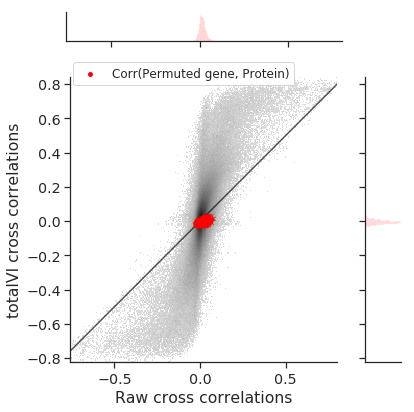

In [23]:
# Plot totalVI spearman correlations
# Plot as PNG (marginal plots don't display in PDF)

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(), # proteins, permuted genes
    totalVI_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True
)

ax = g.ax_joint

ax.hist2d(
    raw_corr[-num_pro:, :-num_pro].ravel(), # proteins, all genes (including permuted)
    totalVI_corr[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.86, .95), prop={'size': 12})

legend.legendHandles[0]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("totalVI cross correlations")

plt.tight_layout()


g.savefig("figures/good_correlations_spearman_log.png", bbox_inches="tight", dpi = DPI, transparent = True) 

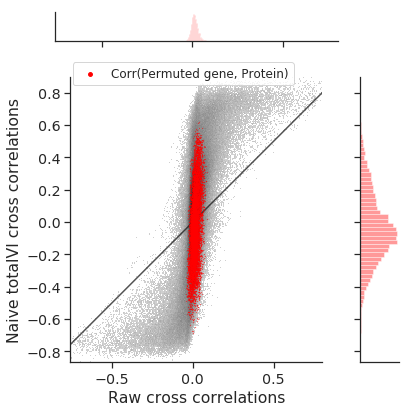

In [24]:
# Plot naive denoised correlations
# Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    totalVI_bad_corr[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True,
)

ax = g.ax_joint

g.ax_joint.hist2d(
    raw_corr[-num_pro:, :-num_pro].ravel(),
    totalVI_bad_corr[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.91, .95), prop={'size': 12}) # 0.89, 0.87

legend.legendHandles[0]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("Naive totalVI cross correlations")

plt.tight_layout()

g.savefig("figures/bad_correlations_spearman_log.png", bbox_inches="tight", dpi = DPI, transparent = True)

### Calculate Pearson correlations

In [25]:
# Calculate totalVI correlations

totalVI_corr_pearson = full_posterior.generate_feature_correlation_matrix(correlation_mode="pearson", n_samples=2, 
                                                                          log_transform = True,
                                                                         rna_size_factor = 1e4)

In [26]:
# Calculate naive denoised correlations

#denoised_genes, denoised_proteins = full_posterior.get_normalized_denoised_expression(n_samples=25, give_mean=True)
totalVI_bad_corr_pearson = np.corrcoef(np.concatenate([denoised_genes, denoised_proteins], axis=1), rowvar=False)

In [27]:
same_gene_inds = np.where(anndataset[:, anndataset.var["hvg_encode"]].var["encode"] != "None")[0]

In [28]:
# Calculate raw correlations

# Raw log normalized
raw_corr_pearson = np.corrcoef(np.concatenate([raw_rna_adata.X, log_protein], axis=1), rowvar = False)

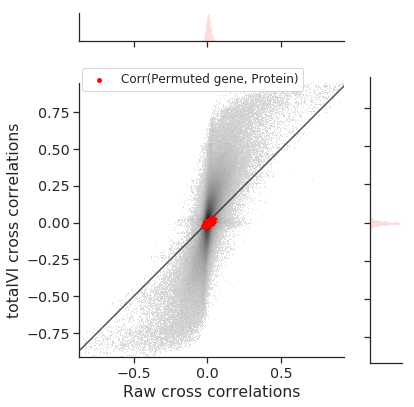

In [29]:
# Plot totalVI pearson correlations
# Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(), # proteins, permuted genes
    totalVI_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True
)

ax = g.ax_joint

ax.hist2d(
    raw_corr_pearson[-num_pro:, :-num_pro].ravel(), # proteins, all genes (including permuted)
    totalVI_corr_pearson[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.87, .95), prop={'size': 12})

legend.legendHandles[0]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("totalVI cross correlations")

plt.tight_layout()


g.savefig("figures/good_correlations_pearson_log.png", bbox_inches="tight", dpi = DPI, transparent = True) # plt

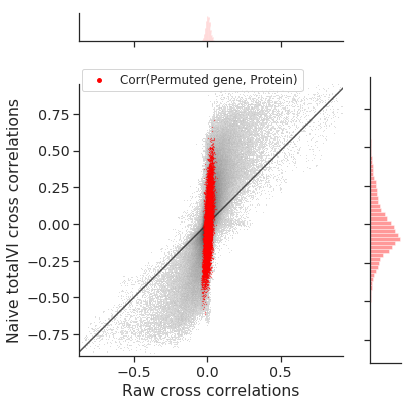

In [30]:
# Plot naive denoised correlations
# Plot as PNG

num_pro = dataset.protein_expression.shape[1]

g = sns.jointplot(
    raw_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    totalVI_bad_corr_pearson[-num_pro:, -num_pro - num_control_genes : -num_pro].ravel(),
    s=0.05,
    color="red",
    label="Corr(Permuted gene, Protein)",
    zorder=2,
    height=6,
    rasterized=True,
)

ax = g.ax_joint

g.ax_joint.hist2d(
    raw_corr_pearson[-num_pro:, :-num_pro].ravel(),
    totalVI_bad_corr_pearson[-num_pro:, :-num_pro].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=plt.cm.gray_r,
    rasterized=True,
)

legend = ax.legend(loc=4, bbox_to_anchor=(0.87, .95), prop={'size': 12}) 

legend.legendHandles[0]._sizes = [15]

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot([-1, 1], [-1, 1], "k-", alpha=0.75, zorder=1)
ax.set_aspect("equal")

sns.despine()
ax.set_xlabel("Raw cross correlations")
ax.set_ylabel("Naive totalVI cross correlations")

plt.tight_layout()

g.savefig("figures/bad_correlations_pearson_log.png", bbox_inches="tight", dpi = DPI, transparent = True)